In [1]:
import os
from pathlib import Path
from IPython.display import Image, display
os.chdir("/Users/oliverdaniels-koch/projects/elk-experiments")
out_dir = Path("output")
device = "mps"

# Explore EAP Graphs on Hex

I'm curious if we see notable differences when running (aggregated) edge attribution patching 
on the trusted and untrusted data of the hex task

I suspect there's a lot of in-distribution variation, but maybe we'll see two distinct circuits?

I also want to create a detector using k-means clustering?

I guess there's just a bunch of ways to learn a latent space of the adjacency / score matrix

Seems like there should be something smarter 

In [2]:
from functools import partial


import torch 
import numpy as np

from eap.eap_wrapper import EAP
from eap.eap_graph import EAPGraph
from cupbearer.tasks import tiny_natural_mechanisms
from elk_experiments.tiny_natural_mechanisms_utils import get_task_subset
from elk_experiments.utils import learn_graph_cache


In [3]:
task_name = "ifelse"
model_name = "pythia-70m"

In [4]:
task = tiny_natural_mechanisms(task_name, device, model_name)


Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  mps


/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m into HookedTransformer
Moving model to device:  mps


In [5]:
graph_dir = out_dir / f"subset_graphs_{task_name}_{model_name}"
graph_dir.mkdir(exist_ok=True)

In [6]:
task.model.set_use_hook_mlp_in(True)
task.model.set_use_split_qkv_input(True)
task.model.set_use_attn_result(True)

In [7]:
small_task = get_task_subset(task, 2048, 1048, 1024)

In [8]:
# use mean probability over effect tokens as metric 
def effect_prob_func(logits, effect_tokens):
    assert logits.ndim == 3
    # Sum over vocab and batch dim (for now we're just computing attribution values, we'll deal with per data instance later)
    probs = logits[:, -1, :].softmax(dim=-1)
    out = probs[:, effect_tokens].mean(dim=-1).mean() # mean over effect tokens, mean over batch
    # out = logits[:, -1, effect_tokens].mean()
    return out

In [9]:
from cupbearer.tasks.tiny_natural_mechanisms import get_effect_tokens
effect_tokens = get_effect_tokens(task_name, task.model)

In [10]:
trusted_tokens = torch.stack([torch.tensor(data["prefix_tokens"]) for data in small_task.trusted_data.data])
untrusted_clean_tokens = torch.stack([torch.tensor(data["prefix_tokens"]) for data in small_task.test_data.normal_data.data])
anomalous_tokens = torch.stack([torch.tensor(data["prefix_tokens"]) for data in small_task.test_data.anomalous_data.data])

In [11]:
threshold = 2e-6

## Trusted Data Graph

In [36]:
clean_graph_path = graph_dir / "clean_graph.pt"
task.model.reset_hooks()

clean_graph = learn_graph_cache(
    model=task.model,
    tokens=trusted_tokens,
    metric=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    batch_size=128,
    cache_path=clean_graph_path,
    verbose=True
)

Saving activations requires 0.0001 GB of memory per token


In [37]:
clean_graph.top_edges(n=20, abs_scores=False)

[('head.0.3', 'head.1.1.v', 5.559661985898856e-06),
 ('head.0.6', 'head.3.3.v', 5.269548637443222e-06),
 ('head.0.3', 'head.1.3.v', 5.163328751223162e-06),
 ('head.0.3', 'head.1.4.v', 3.380461976121296e-06),
 ('head.0.0', 'head.1.6.v', 2.9738814646407263e-06),
 ('head.0.6', 'head.1.0.v', 2.856041874110815e-06),
 ('head.0.0', 'head.3.7.v', 2.6508582777751144e-06),
 ('head.0.3', 'head.2.0.v', 2.5859685592877213e-06),
 ('head.0.0', 'head.2.6.v', 2.431959956084029e-06),
 ('head.0.6', 'head.2.2.v', 2.379960733378539e-06),
 ('head.0.1', 'head.2.5.v', 2.368967898291885e-06),
 ('head.0.5', 'head.1.0.v', 2.3241032067744527e-06),
 ('head.2.0', 'head.3.7.v', 2.320241492270725e-06),
 ('head.0.3', 'head.1.2.v', 1.991269755308167e-06),
 ('head.0.0', 'head.2.5.v', 1.9279777916381136e-06),
 ('head.2.2', 'head.3.2.v', 1.8308096514374483e-06),
 ('head.0.1', 'head.3.4.v', 1.7554780242790002e-06),
 ('head.0.0', 'head.1.6.q', 1.7022356360030244e-06),
 ('head.0.6', 'head.3.1.v', 1.6879980648809578e-06),
 ('

Saving graph


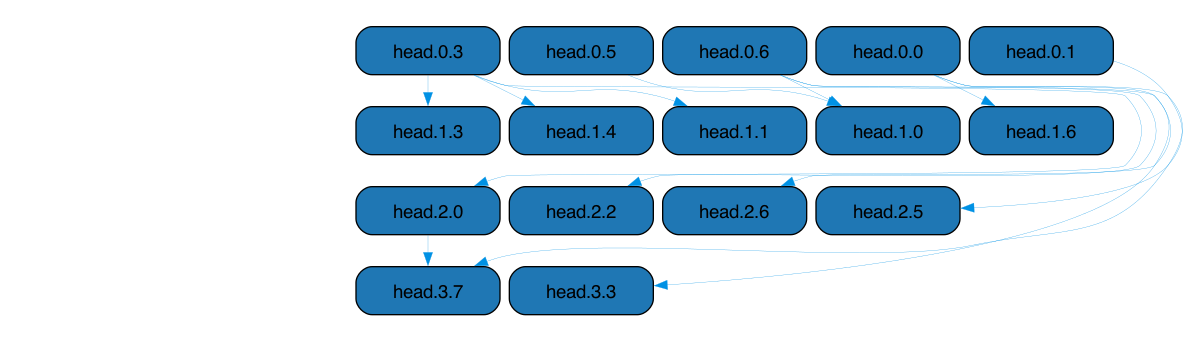

In [38]:
fname = "clean_graph.png"
clean_graph.show(threshold=threshold, abs_scores=False, fdir=graph_dir, fname=fname)
display(Image(graph_dir / fname))

In [39]:
clean_edges = clean_graph.top_edges(threshold=threshold, abs_scores=False)
len(clean_edges)

13

## Anomalous Data Graph

In [40]:
anomalous_graph_path = graph_dir / "anomalous_graph.pt"

task.model.reset_hooks()

anomalous_graph = learn_graph_cache(
    model=task.model,
    tokens=anomalous_tokens,
    metric=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    batch_size=128,
    cache_path=anomalous_graph_path,
    verbose=True
)

Saving activations requires 0.0001 GB of memory per token


Saving graph


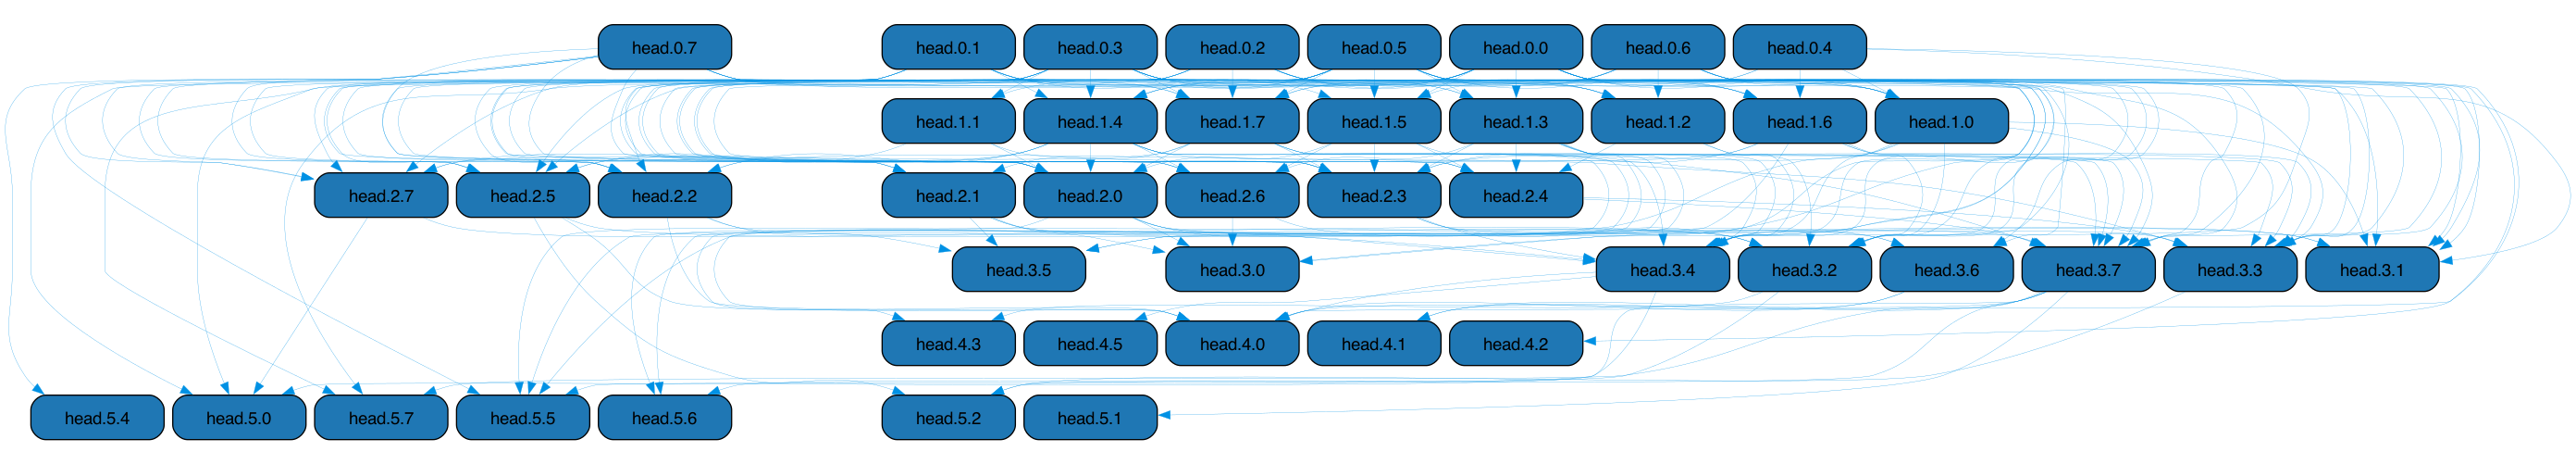

In [41]:
fname = "anom_graph.png"
anomalous_graph.show(threshold=threshold, abs_scores=False, fdir=graph_dir, fname=fname)
display(Image(graph_dir / fname))

In [42]:
anomalous_edges = anomalous_graph.top_edges(threshold=threshold, abs_scores=False)
len(anomalous_edges)

211

## Untrusted Clean Data Graph

In [43]:
task.model.reset_hooks()

untrusted_clean_path = graph_dir / "untrusted_clean_graph.pt"

untrusted_clean_graph = learn_graph_cache(
    model=task.model,
    tokens=untrusted_clean_tokens,
    metric=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    batch_size=128,
    cache_path=untrusted_clean_path,
    verbose=True
)

Saving activations requires 0.0001 GB of memory per token


In [44]:
threshold

2e-06

In [45]:
untrusted_clean_graph.top_edges(threshold=2e-6, abs_scores=False)

[('head.0.3', 'head.1.1.v', 3.865581675199792e-06),
 ('head.0.6', 'head.3.3.v', 2.201312554461765e-06),
 ('head.0.0', 'head.3.7.v', 2.0198958736727946e-06)]

Saving graph


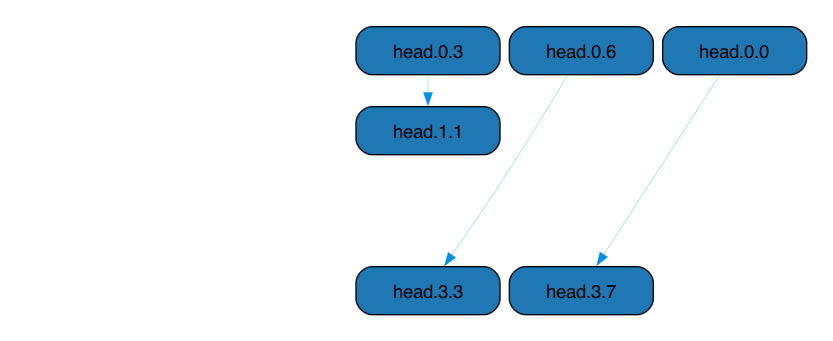

In [46]:
fname = "untrusted_clean_graph.png"
untrusted_clean_graph.show(threshold=2e-6, abs_scores=False, fdir=graph_dir, fname=fname)
display(Image(graph_dir / fname))

In [47]:
untrusted_clean_edges = untrusted_clean_graph.top_edges(threshold=threshold, abs_scores=False)
len(untrusted_clean_edges)

3

## Combined Graph

In [98]:
all_tokens = torch.cat([trusted_tokens, anomalous_tokens, untrusted_clean_tokens])

In [99]:
full_graph_path = graph_dir / "full_graph.pt"

task.model.reset_hooks()

full_graph = learn_graph_cache(
    task.model,
    all_tokens,
    partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    batch_size=128,
    cache_path=full_graph_path,
    verbose=True
)

Saving activations requires 0.0001 GB of memory per token


Saving graph


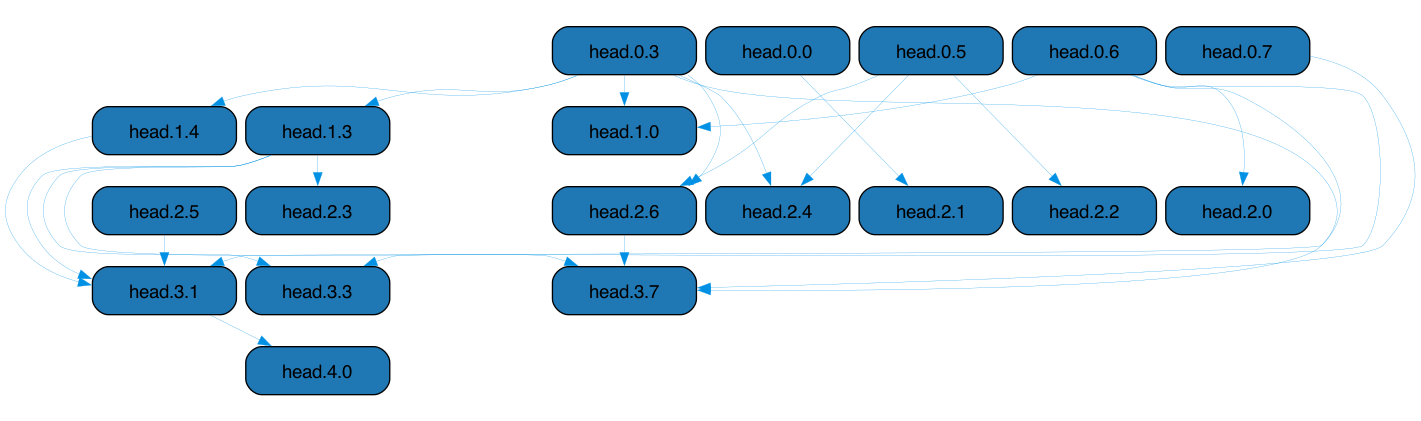

In [100]:
fname = "full_graph.png"
full_graph.show(threshold=threshold, abs_scores=False, fname=fname, fdir=graph_dir)
display(Image(graph_dir / fname))

In [102]:
full_edges = full_graph.top_edges(threshold=threshold, abs_scores=False)
len(full_edges)

23

# Untrusted Combined

In [103]:
untrusted_tokens = torch.cat([anomalous_tokens, untrusted_clean_tokens])

In [104]:
untrusted_path = graph_dir / "untrusted_graph.pt"

task.model.reset_hooks()

untrusted_graph = learn_graph_cache(
    task.model,
    untrusted_tokens,
    partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    batch_size=128,
    cache_path=untrusted_path,
    verbose=True
)

Saving activations requires 0.0001 GB of memory per token


Saving graph


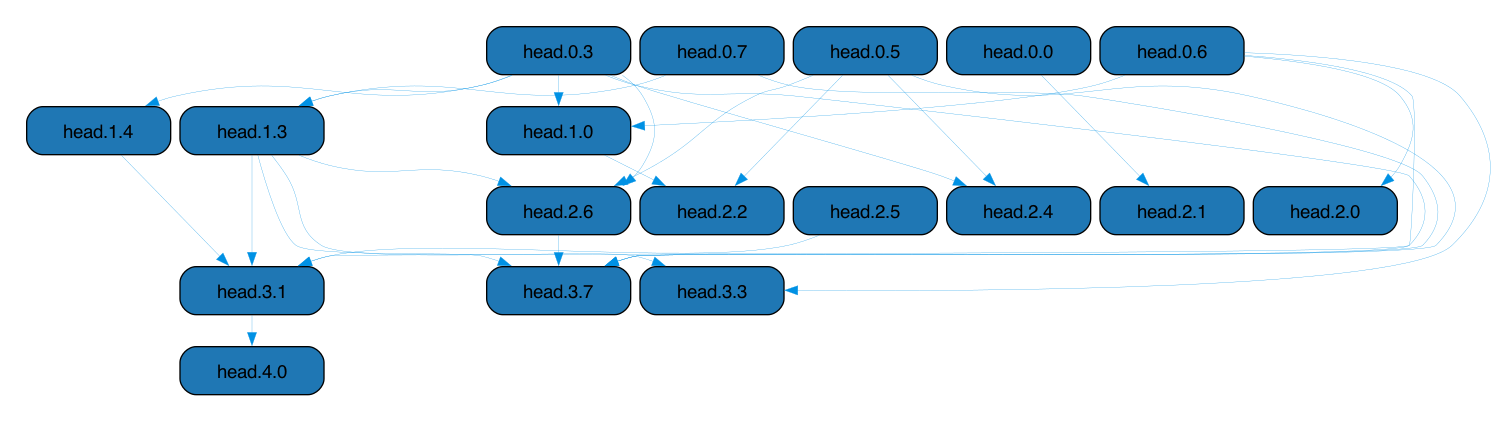

In [106]:
fname = "untrusted_graph.png"
untrusted_graph.show(threshold=threshold, abs_scores=False, fname=fname, fdir=graph_dir)
display(Image(graph_dir / fname))

In [111]:
untrusted_edges = untrusted_graph.top_edges(threshold=threshold, abs_scores=False)
len(untrusted_edges)

26

# Detectors

In [12]:
from elk_experiments.utils import train_detector_cache
from elk_experiments.eap_detector import EAPDetector
from cupbearer.detectors import ActivationCache
from cupbearer.detectors import MahalanobisDetector
from cupbearer import utils

In [13]:
class EAPMahalanobisDetector(EAPDetector, MahalanobisDetector):
    pass

## Standard Detector

In [14]:
# maybe the problem is that the psedoinverse basically compresses the dimensions of variation between the training and test data

# should try more basic method (number of anomolous edges)

In [18]:
cache = ActivationCache(device)
detector_dir = graph_dir / "standard_detector"

detector = EAPMahalanobisDetector(
    effect_prob_func=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    edge_filter=lambda x: True,
    seq_len=16,
    layer_aggregation="mean", 
    cache=cache
)

In [19]:
small_task = get_task_subset(task, 2048, 1024, 1024)

/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
2024-07-02 12:19:38.434 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:83 - Activation sizes: 
eap_scores: torch.Size([4032])
100%|██████████| 32/32 [02:01<00:00,  3.78s/it]
2024-07-02 12:21:51.619 | INFO     | cupbearer.detectors.anomaly_detector:save_weights:257 - Saving detector to output/subset_graphs_ifelse_pythia-70m/standard_detector/detector


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-07-02 12:23:57.196 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.9030
2024-07-02 12:23:57.197 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.8708


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.9030303955078125,
               'AP': 0.8708120634497207}}),
 {'all': <Figure size 640x480 with 1 Axes>})

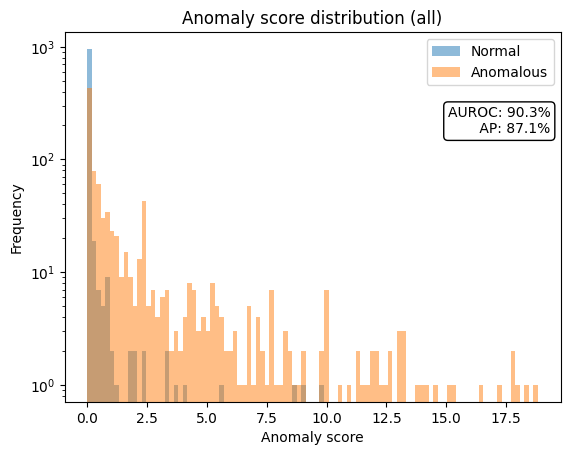

In [20]:
train_detector_cache(
    detector_dir=detector_dir,
    detector=detector,
    task=task,
    batch_size=64,
    eval_batch_size=64,
    cache=cache,
    overwrite=True
)

In [1]:
detector.graph.eap_scores

NameError: name 'detector' is not defined

# Detectors Using EAP Graphs

In [116]:
def edge_set_filter(edge, edge_set: list[tuple[str, str]]):
    return tuple(edge) in edge_set

## Edge Thresold Count Detector

## Filtering Detector by specific edges (from "pretraining" across dataset)

In [25]:
full_edges_names = [edge[:2] for edge in full_edges]

In [27]:
detector_dir = out_dir / "pythia-70m-hex-small-edge_filtered"

In [28]:
cache = ActivationCache(device=device)

In [29]:
detector = EAPMahalanobisDetector(
    effect_prob_func=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    edge_filter=partial(edge_set_filter, edge_set=full_edges_names),
    seq_len=16,
    layer_aggregation="mean", 
    cache=cache
)

In [33]:
detector.load_weights(detector_dir / "detector.pth")

2024-07-02 10:03:33.220 | INFO     | cupbearer.detectors.anomaly_detector:load_weights:261 - Loading detector from output/pythia-70m-hex-small-edge_filtered/detector.pth


/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
2024-07-02 09:31:06.912 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:83 - Activation sizes: 
eap_scores: torch.Size([27])
100%|██████████| 32/32 [01:46<00:00,  3.32s/it]
2024-07-02 09:32:53.102 | INFO     | cupbearer.detectors.anomaly_detector:save_weights:257 - Saving detector to output/pythia-70m-hex-small-edge_filtered/detector


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-07-02 09:34:43.355 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.5886
2024-07-02 09:34:43.356 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.6021


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.5885825157165527,
               'AP': 0.6020555256780303}}),
 {'all': <Figure size 640x480 with 1 Axes>})

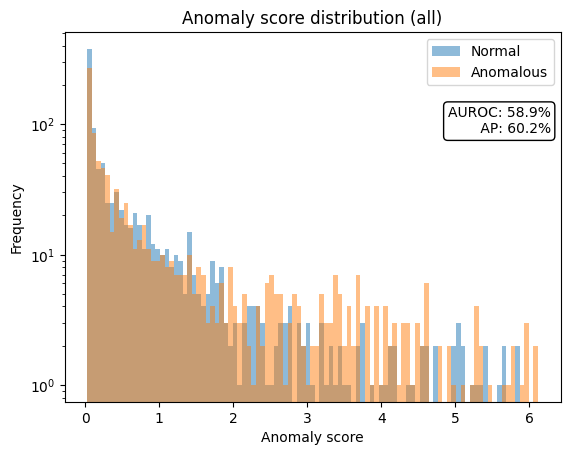

: 

In [47]:
train_detector_cache(
    detector_dir, detector, small_task, batch_size=64, eval_batch_size=64, cache=cache, 
    cache_path=None, overwrite=True, overwrite_cache=True
)

In [39]:
detector.inv_covariances["eap_scores"].min()

tensor(-2.2440e+14, device='mps:0')

# Filter Detector by Edge Difference Between Untrusted and Trusted

In [118]:
trusted_edge_names = [edge[:2] for edge in clean_edges]
untrusted_edge_names = [edge[:2] for edge in untrusted_edges]
edge_diff = set(untrusted_edge_names) - set(trusted_edge_names)
len(edge_diff)


7

In [113]:
edge_diff

{('head.0.5', 'head.2.6.k'),
 ('head.0.5', 'head.3.7.v'),
 ('head.0.6', 'head.2.0.v'),
 ('head.0.7', 'head.1.3.v'),
 ('head.1.0', 'head.2.2.v'),
 ('head.1.3', 'head.2.6.q'),
 ('head.1.3', 'head.3.1.v')}

In [120]:
detector_dir = out_dir / "pythia-70m-hex-small-untrusted_diff"

In [121]:
cache = ActivationCache(device=device)

In [122]:
detector = EAPMahalanobisDetector(
    effect_prob_func=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    edge_filter=partial(edge_set_filter, edge_set=edge_diff),
    seq_len=16,
    layer_aggregation="mean", 
    cache=cache
)

/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
2024-07-02 11:16:38.427 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:83 - Activation sizes: 
eap_scores: torch.Size([7])
100%|██████████| 32/32 [01:59<00:00,  3.74s/it]
2024-07-02 11:18:38.121 | INFO     | cupbearer.detectors.anomaly_detector:save_weights:257 - Saving detector to output/pythia-70m-hex-small-untrusted_diff/detector


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-07-02 11:20:32.873 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.5894
2024-07-02 11:20:32.874 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.6020


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.589385986328125,
               'AP': 0.6020046879847654}}),
 {'all': <Figure size 640x480 with 1 Axes>})

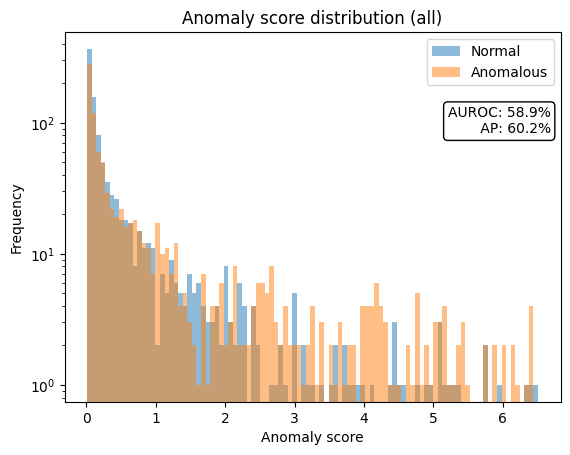

In [123]:
train_detector_cache(
    detector_dir, detector, small_task, batch_size=128, eval_batch_size=128, cache=cache, 
    cache_path=None, overwrite=True, overwrite_cache=True
)

In [131]:
detector.means["eap_scores"]

tensor([3.4862e-08, 5.0482e-08, 6.0033e-08, 2.5515e-08, 4.5435e-08, 2.4964e-08,
        5.3383e-08], device='mps:0')

In [128]:
detector.covariances["eap_scores"].diag()

tensor([6.5552e-14, 8.4426e-15, 1.2563e-14, 4.0145e-14, 7.2989e-15, 5.4749e-14,
        2.0972e-14], device='mps:0')

# Try Getting Top Edges across Entire Distribution, filtering anomolies with respect to that